In [1]:
# https://ronxin.github.io/wevi/

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from konlpy.tag import Mecab
mecab = Mecab()

np.random.seed(777)

In [2]:
sentences = [
"전자 A 스마트기기 A 아이폰 A",
"전자 A 스마트기기 A 애플 A",
"전자 A 스마트기기 A 맥북 A",
"전자 B 가전기기 B 공기청정기 B",
"전자 B 가전기기 B 냉장고 B",
"생활 C 티슈 C",
"생활 C 기저귀 C",
"생활 D 쓰레빠 D",
"생활 D 빗자루 D",
"생활 D 쓰레받이 D",
"생활 D 대걸레 D",
"전자 E 스마트기기 E 갤럭시S E",
"전자 E 스마트기기 E 갤럭시패드 E",
"전자 E 스마트기기 E 아이패드 E",
"생활 F 방향제 F 패브리즈 F",
"생활 F 청소도구 F 락스 F",
"생활 F 청소도구 F 팡이제로 F",
]

In [3]:
# sentence_pos = []
# for i in sentences:
#     t = []
#     for k, p in mecab.pos(i):
#         p = p.replace('+','')
#         if len(k) > 0:
#             t.append('{0}_{1}'.format(k, p))
#     sentence_pos.append(' '.join(t))
# sentence_pos

In [4]:
skimgram = []
words_max = 0

def get_skimgram(sentence, ws=1):
    skip_grams = []
    last_idx = len(sentence)-1
    for idx, item in enumerate(sentence):
        # (context, target) 쌍의 dataset, 관계를 규정할 수 있는 범위로 처리
        prev_w_idx = idx-ws
        next_w_idx = idx+ws
        if prev_w_idx >= 0 and next_w_idx <= last_idx:
            target = sentence[idx]
            if len(target) > 0 and len(sentence[prev_w_idx]) > 0 and len(sentence[next_w_idx]) > 0:
                skip_grams.append([target, sentence[prev_w_idx]])
                skip_grams.append([target, sentence[next_w_idx]])

    return skip_grams

skimgram = get_skimgram(' '.join(sentences).split(' '))
skimgram
sentences

['전자 A 스마트기기 A 아이폰 A',
 '전자 A 스마트기기 A 애플 A',
 '전자 A 스마트기기 A 맥북 A',
 '전자 B 가전기기 B 공기청정기 B',
 '전자 B 가전기기 B 냉장고 B',
 '생활 C 티슈 C',
 '생활 C 기저귀 C',
 '생활 D 쓰레빠 D',
 '생활 D 빗자루 D',
 '생활 D 쓰레받이 D',
 '생활 D 대걸레 D',
 '전자 E 스마트기기 E 갤럭시S E',
 '전자 E 스마트기기 E 갤럭시패드 E',
 '전자 E 스마트기기 E 아이패드 E',
 '생활 F 방향제 F 패브리즈 F',
 '생활 F 청소도구 F 락스 F',
 '생활 F 청소도구 F 팡이제로 F']

In [5]:
word = {}
for i in skimgram:
    word[i[0]] = 1
    word[i[1]] = 1

words_max = len(list(word.keys()))
words_max

29

In [6]:
vocabproc = tf.contrib.learn.preprocessing.VocabularyProcessor(words_max)
fit_sentence = vocabproc.fit_transform(sentences)
vocab_dict = vocabproc.vocabulary_._mapping
word_index = sorted(vocab_dict.items(), key=lambda x: x[1])
word_index

[('<UNK>', 0),
 ('전자', 1),
 ('A', 2),
 ('스마트기기', 3),
 ('아이폰', 4),
 ('애플', 5),
 ('맥북', 6),
 ('B', 7),
 ('가전기기', 8),
 ('공기청정기', 9),
 ('냉장고', 10),
 ('생활', 11),
 ('C', 12),
 ('티슈', 13),
 ('기저귀', 14),
 ('D', 15),
 ('쓰레빠', 16),
 ('빗자루', 17),
 ('쓰레받이', 18),
 ('대걸레', 19),
 ('E', 20),
 ('갤럭시S', 21),
 ('갤럭시패드', 22),
 ('아이패드', 23),
 ('F', 24),
 ('방향제', 25),
 ('패브리즈', 26),
 ('청소도구', 27),
 ('락스', 28),
 ('팡이제로', 29)]

In [19]:
batch_size = 5
# batch_size 보다 작아야 합니다.
num_sampled = 2
embed_size = 2
voc_size = len(word_index)

In [20]:
inputs = tf.placeholder(tf.int32, [batch_size])
labels = tf.placeholder(tf.int32, [batch_size, 1])

In [21]:
embed = tf.Variable(tf.random_uniform([voc_size, embed_size], -1., 1.), name='word_embed')
sel_embed = tf.nn.embedding_lookup(embed, inputs)

In [22]:
nce_weights = tf.Variable(tf.random_uniform([voc_size, embed_size], -1.0, 1.0), name='w')
nce_biases = tf.Variable(tf.zeros([voc_size]), name='b')

In [23]:
loss = tf.reduce_mean(
    tf.nn.nce_loss(
        weights=nce_weights, 
        biases=nce_biases, 
        inputs=sel_embed, 
        labels=labels, 
        num_sampled=num_sampled, 
        num_classes=voc_size
    )
)

In [32]:
train = tf.train.AdamOptimizer(0.01).minimize(loss)

In [33]:
# vocab_dict

In [34]:
def random_batch(data, size):
    random_inputs = []
    random_labels = []
    
    for i in (np.random.choice(range(len(data)), size, replace=False)):
        random_inputs.append(vocab_dict[data[i][0]])
        random_labels.append([vocab_dict[data[i][1]]])
            
    return random_inputs, random_labels

batch_inputs, batch_labels = random_batch(skimgram, batch_size)

In [35]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(10000):
    batch_inputs, batch_labels = random_batch(skimgram, batch_size)
    
    _, c = sess.run([train, loss], feed_dict={inputs: batch_inputs, labels: batch_labels})

    if epoch % 1000 == 0:
        print("epoch ", epoch, ": ", c)
        
train_embed = sess.run(embed)

epoch  0 :  4.23448
epoch  1000 :  1.21798
epoch  2000 :  1.4425
epoch  3000 :  0.786467
epoch  4000 :  2.77767
epoch  5000 :  0.997183
epoch  6000 :  0.681563
epoch  7000 :  1.72505
epoch  8000 :  0.833349
epoch  9000 :  1.29181


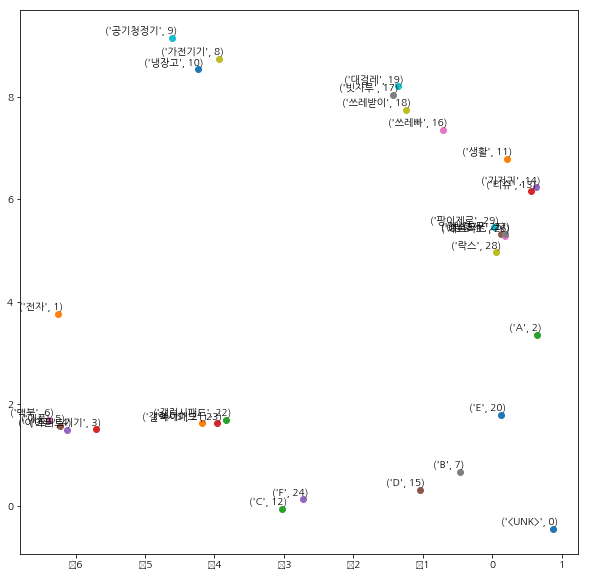

In [36]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,10)

# train_embed = train_embed[1:]
# word_index = word_index[1:]

for i, label in enumerate(word_index):
    x, y = train_embed[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

plt.show()

In [37]:
# from sklearn.manifold import TSNE
# tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000) 
# # 여기서 중요한 것은 n_components만큼 차원을 축소함. Cartarian 좌표계로 시각화하기 위해 2차원으로 축소.
# vectors_simple = tsne.fit_transform(train_embed)

In [38]:
sess.close()